In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import MathsUtilities as MUte
import sqlite3

%matplotlib inline

In [2]:
DBFilePath = r"C:/GitHubRepos/ApsimX/Prototypes/Lentil/Lentil.db"
con = sqlite3.connect(DBFilePath)
try:
    Sims = pd.read_sql("Select * from _Simulations",con)
    Sims.set_index('ID',inplace=True)
    Factors = pd.read_sql("Select * from _Factors",con)
    Factors.loc[:,'Name'] = [Sims.loc[Factors.loc[x,'SimulationID'],'Name'] for x in Factors.index]
    Factors.set_index('Name', inplace = True)
    SowReport = pd.read_sql("Select * from SowingReport",con)
    SowReport.loc[:,'Name'] = [Sims.loc[SowReport.loc[x,'SimulationID'],'Name'] for x in SowReport.index]
    SowReport.set_index('Name', inplace = True)
    SowReport.loc[:,'Clock.Today'] = pd.to_datetime(SowReport.loc[:,'Clock.Today'])
    SowReport.loc[:,'SowDOY'] = [SowReport.loc[x,'Clock.Today'].dayofyear for x in SowReport.index] 
    Harvest = pd.read_sql("Select * from HarvestReport",con)
    Harvest.loc[:,'Name'] = [Sims.loc[Harvest.loc[x,'SimulationID'],'Name'] for x in Harvest.index]
    Harvest.set_index('Name', inplace = True)
    Daily = pd.read_sql("Select * from DailyReport",con)
    Daily.loc[:,'Name'] = [Sims.loc[Daily.loc[x,'SimulationID'],'Name'] for x in Daily.index]
    Daily.loc[:,'Clock.Today'] = pd.to_datetime(Daily.loc[:,'Clock.Today'])
    Daily.set_index(['Name','Clock.Today'], inplace = True)
    HarvObsPred = pd.read_sql("Select * from HarvestObsPred",con)
    HarvObsPred.loc[:,'Name'] = [Sims.loc[HarvObsPred.loc[x,'SimulationID'],'Name'] for x in HarvObsPred.index]
    HarvObsPred.drop_duplicates(inplace = True)
    HarvObsPred.set_index('Name', inplace = True)
    con.close()
except:
    con.close()
    
Cultivars = SowReport.Cv.drop_duplicates().values

StageNames = ['Emergence','StartBudding','StartFlowering','PodEmergence','Maturity']
ObsStageVarNames = ['Observed.Lentil.Phenology.EmergenceDAS','Observed.Lentil.Phenology.StartBuddingDAS','Observed.Lentil.Phenology.StartFloweringDAS',
                     'Observed.Lentil.Phenology.PodEmergenceDAS','Observed.Lentil.Phenology.MaturityDAS']
ObsStageDAS = ['EmergenceDAS','StartBuddingDAS','StartFloweringDAS','PodEmergenceDAS','MaturityDAS']
ObsStageDate = ['EmergenceDate','StartBuddingDate','StartFloweringDate','PodEmergenceDate','MaturityDate']
ObsStageTt = ['EmergenceTt','StartBuddingTt','StartFloweringTt','PodEmergenceTt','MaturityTt']

Stage = pd.DataFrame(index = StageNames, data = zip(ObsStageDAS,ObsStageDate,ObsStageTt,ObsStageVarNames),columns = ['DAS','Date','Tt','VarName'])

In [3]:
Cultivars

array(['Precoz', 'Laird', 'Syrian', 'Ethiopian', None, 'Blitz', 'Bolt',
       'HallmarkXT', 'Greenfield', 'Jumbo2', 'Ace', 'Digger', 'Nugget',
       'Aldinga', 'Boomer', 'CIPAL0901', 'CIPAL1504', 'CIPAL1701',
       'Commando', 'Flash', 'Giant', 'Hurricane', 'Indianhead', 'Jumbo',
       'Matilda', 'Nipper', 'Northfield'], dtype=object)

In [193]:
Stage

,DAS,Date,Tt,VarName
Emergence,EmergenceDAS,EmergenceDate,EmergenceTt,Observed.Lentil.Phenology.EmergenceDAS
StartBudding,StartBuddingDAS,StartBuddingDate,StartBuddingTt,Observed.Lentil.Phenology.StartBuddingDAS
StartFlowering,StartFloweringDAS,StartFloweringDate,StartFloweringTt,Observed.Lentil.Phenology.StartFloweringDAS
PodEmergence,PodEmergenceDAS,PodEmergenceDate,PodEmergenceTt,Observed.Lentil.Phenology.PodEmergenceDAS
Maturity,MaturityDAS,MaturityDate,MaturityTt,Observed.Lentil.Phenology.MaturityDAS


In [194]:
DAS = HarvObsPred.loc[:,Stage.loc[:,'VarName'].values].drop_duplicates()

In [195]:
ObsPhen = SowReport.loc[:,['Clock.Today', 'Lentil.SowingData.Cultivar', 'IWeather.Latitude','IWeather.Longitude','SowDOY']]
ObsPhen.loc[:,'SowDate'] = ObsPhen.loc[:,'Clock.Today']
for ob in ObsPhen.index:
    try:
        ObsPhen.loc[ob,Stage.loc[:,'DAS'].values] = DAS.loc[ob,Stage.loc[:,'VarName'].values].values
        ObsPhen.loc[ob,Stage.loc[:,'DAS'].values] = pd.to_numeric(ObsPhen.loc[ob,Stage.loc[:,'DAS'].values])
    except:
        oh = 'well' #print(ob)
        
def calcNewDate(oldDate, delta):
    if np.isnan(delta):
        return None
    else:
        return oldDate + dt.timedelta(int(delta))
for s in Stage.index:
    for x in ObsPhen.index:
        ObsPhen.loc[x,Stage.loc[s,'Date']] = calcNewDate(ObsPhen.loc[x,'SowDate'],ObsPhen.loc[x,Stage.loc[s,'DAS']])

Tt = Daily.loc[:,'Lentil.Phenology.AccumulatedTT']
PreEmTt = Daily.loc[:,'Lentil.Phenology.PreEmergenceTt']

In [196]:
def getTt(Tt,sim,date):
    if pd.isnull(date):
        return np.nan
    else:
        return Tt.loc[(sim,date)]
        
#Calculate accumulated Tt using wang model with base of 2
for s in Stage.index:
    ObsPhen.loc[:,Stage.loc[s,'Tt']] = [getTt(Tt,x,ObsPhen.loc[x,Stage.loc[s,'Date']]) for x in ObsPhen.index]
    
#Recalculate emergence Tt using accumulated Tt from linear model with base zero
ObsPhen.loc[:,'EmergenceTt'] = [getTt(PreEmTt,x,ObsPhen.loc[x,'EmergenceDate']) for x in ObsPhen.index]

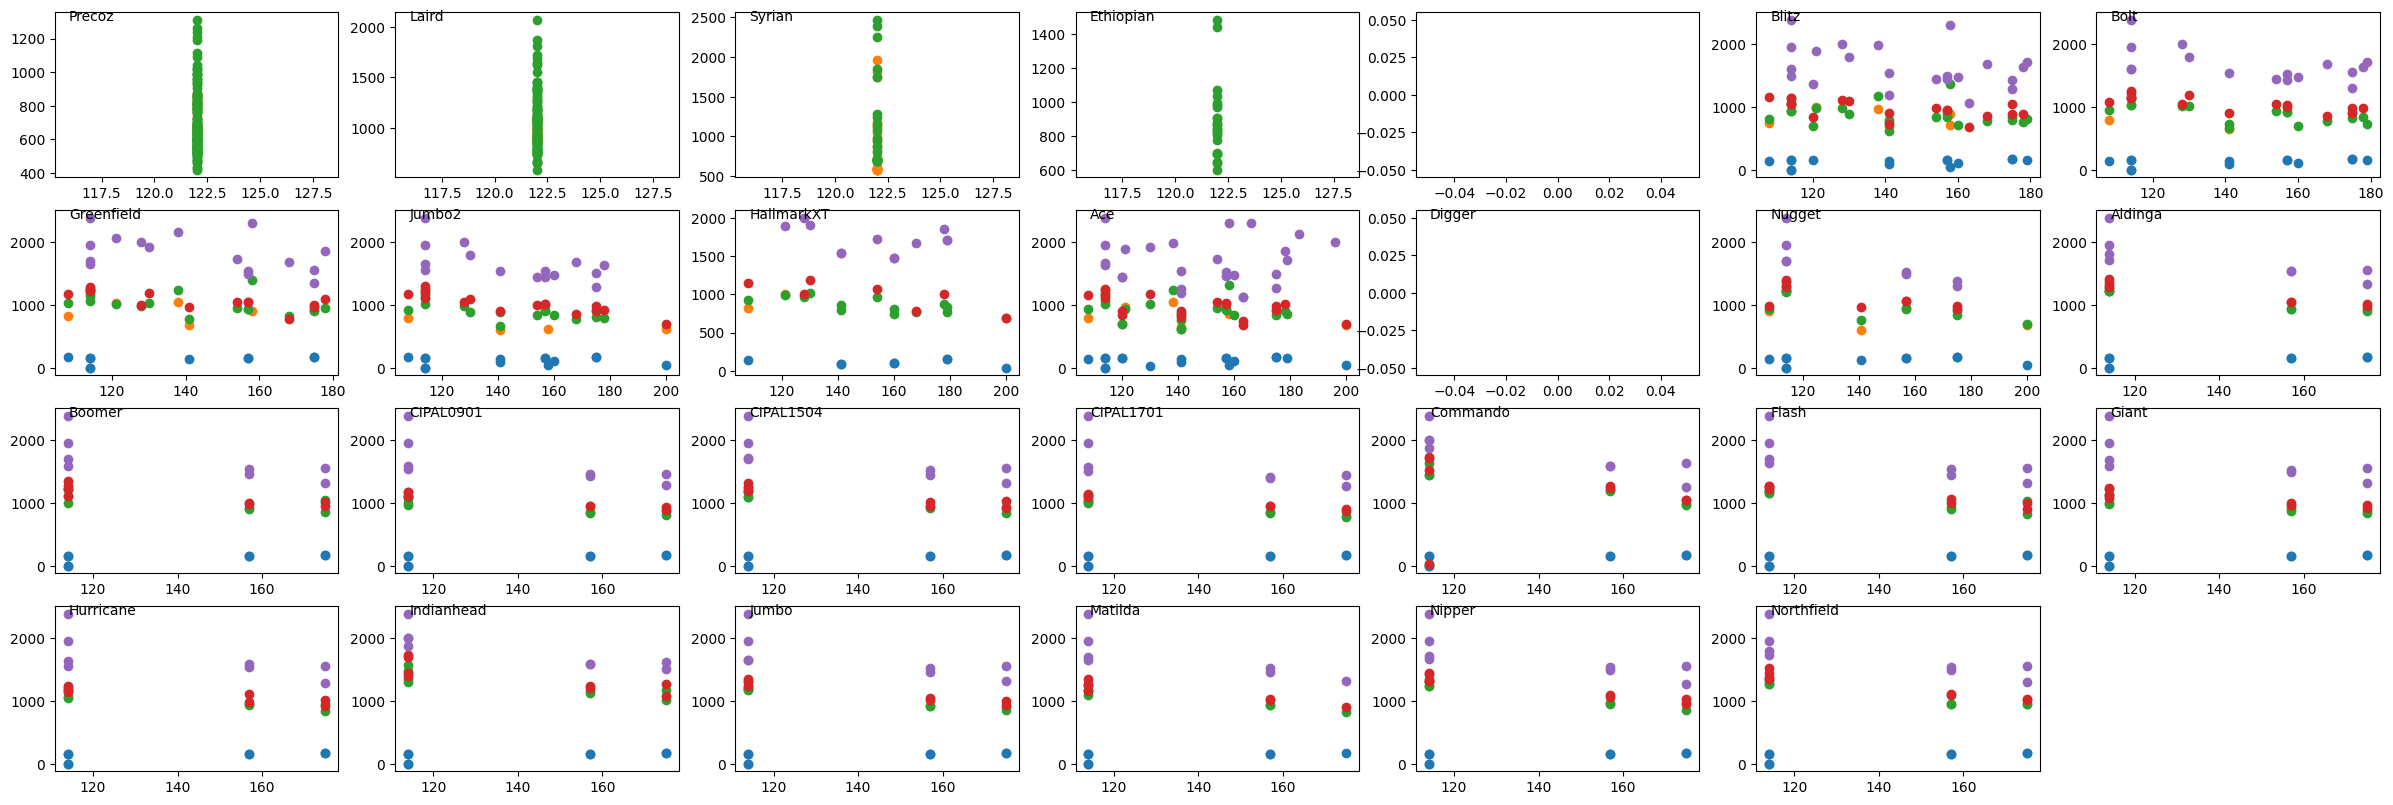

In [197]:
graph = plt.figure(figsize=(30,15))
pos=1
for c in Cultivars:
    ax = graph.add_subplot(6,7,pos)
    cultFilt = ObsPhen.loc[:,'Lentil.SowingData.Cultivar'] == c
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'EmergenceTt'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'StartBuddingTt'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'StartFloweringTt'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'PodEmergenceTt'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'MaturityTt'],'o')
    plt.text(0.05,0.95,c,transform = ax.transAxes)
    pos +=1


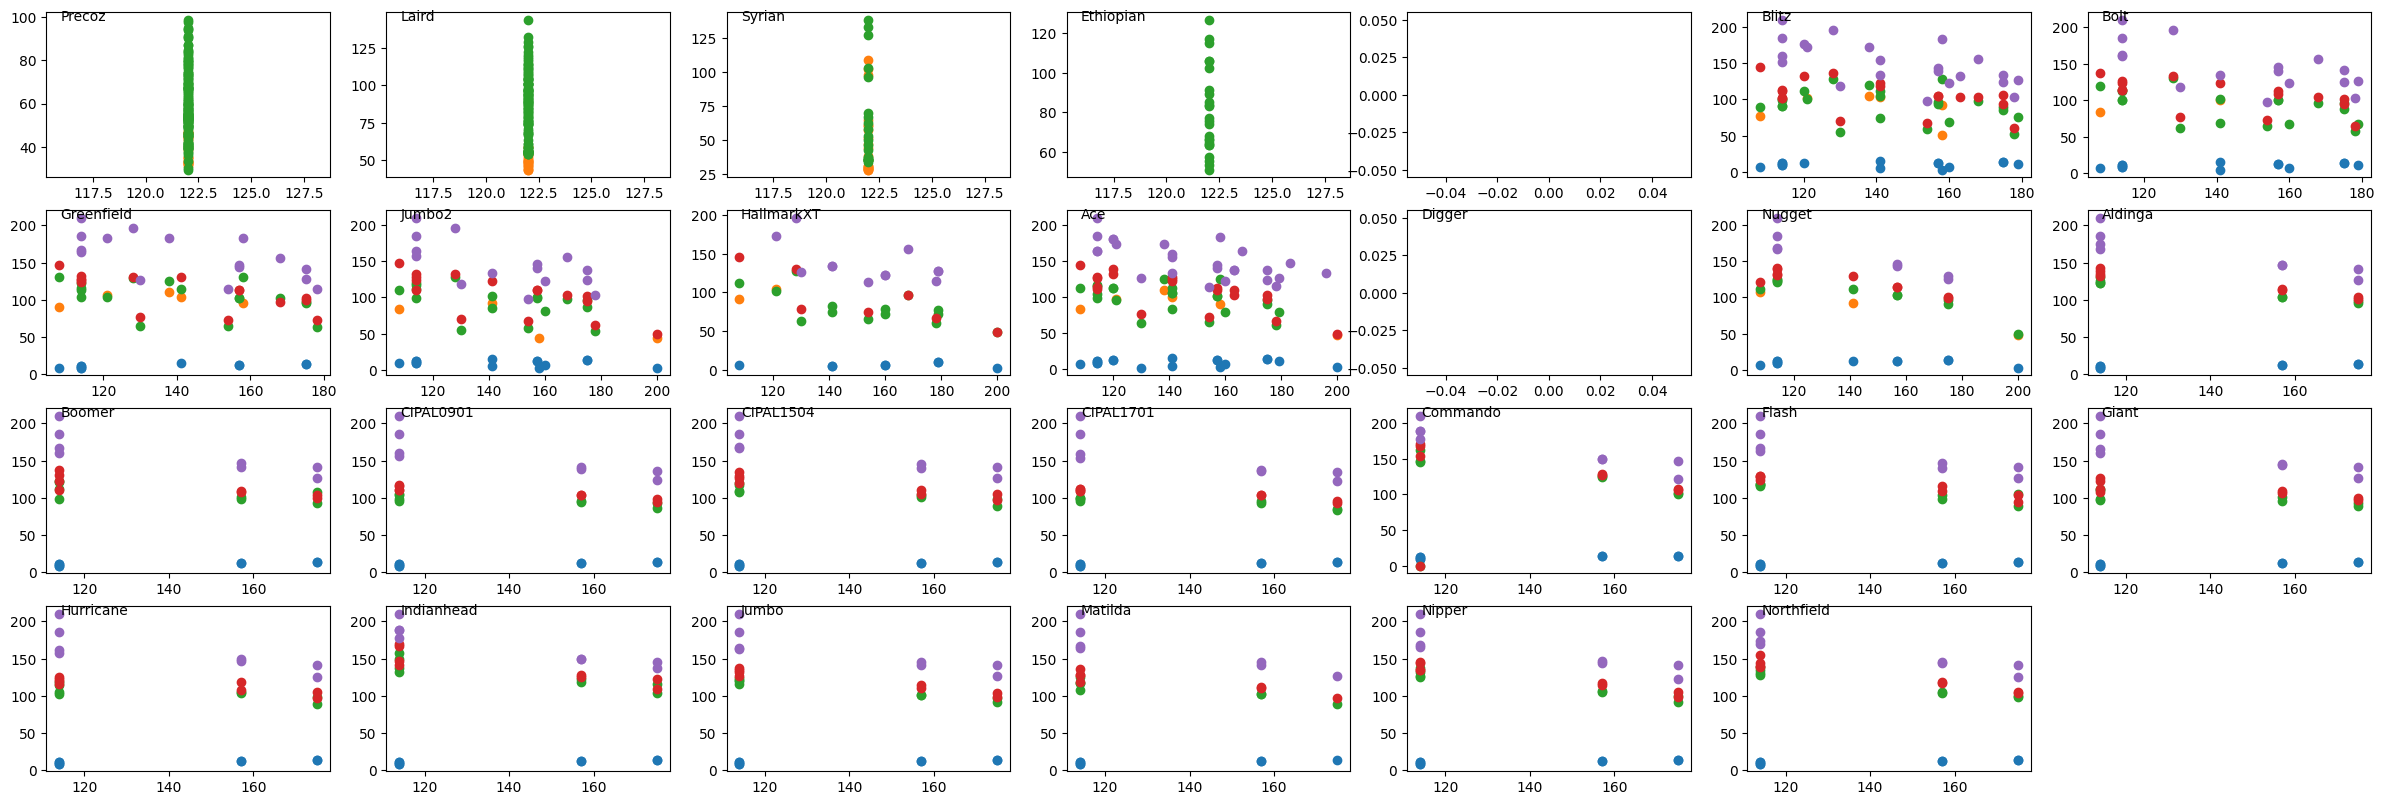

In [198]:
graph = plt.figure(figsize=(30,15))
pos=1
for c in Cultivars:
    ax = graph.add_subplot(6,7,pos)
    cultFilt = ObsPhen.loc[:,'Lentil.SowingData.Cultivar'] == c
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'EmergenceDAS'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'StartBuddingDAS'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'StartFloweringDAS'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'PodEmergenceDAS'],'o')
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'MaturityDAS'],'o')
    plt.text(0.05,0.95,c,transform = ax.transAxes)
    pos +=1


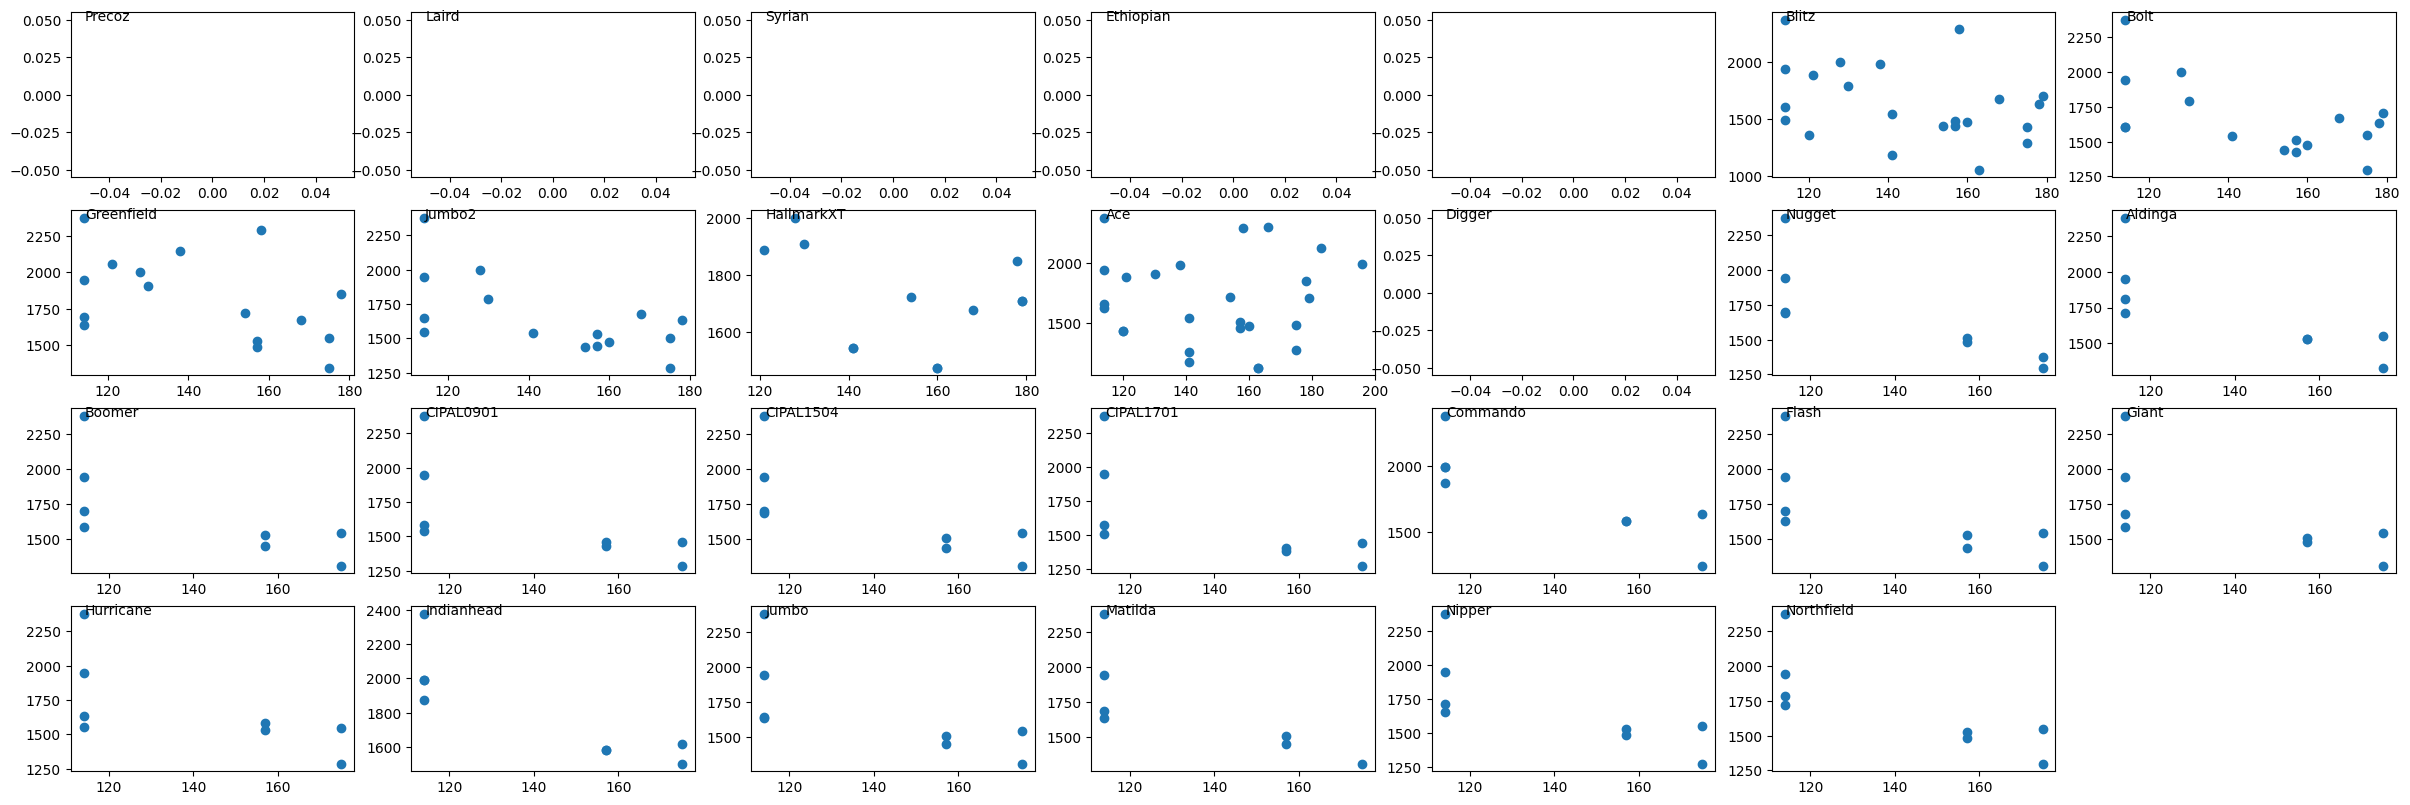

In [199]:
graph = plt.figure(figsize=(30,15))
pos=1
for c in Cultivars:
    ax = graph.add_subplot(6,7,pos)
    cultFilt = ObsPhen.loc[:,'Lentil.SowingData.Cultivar'] == c
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'MaturityTt'],'o')
    plt.text(0.05,0.95,c,transform = ax.transAxes)
    pos +=1


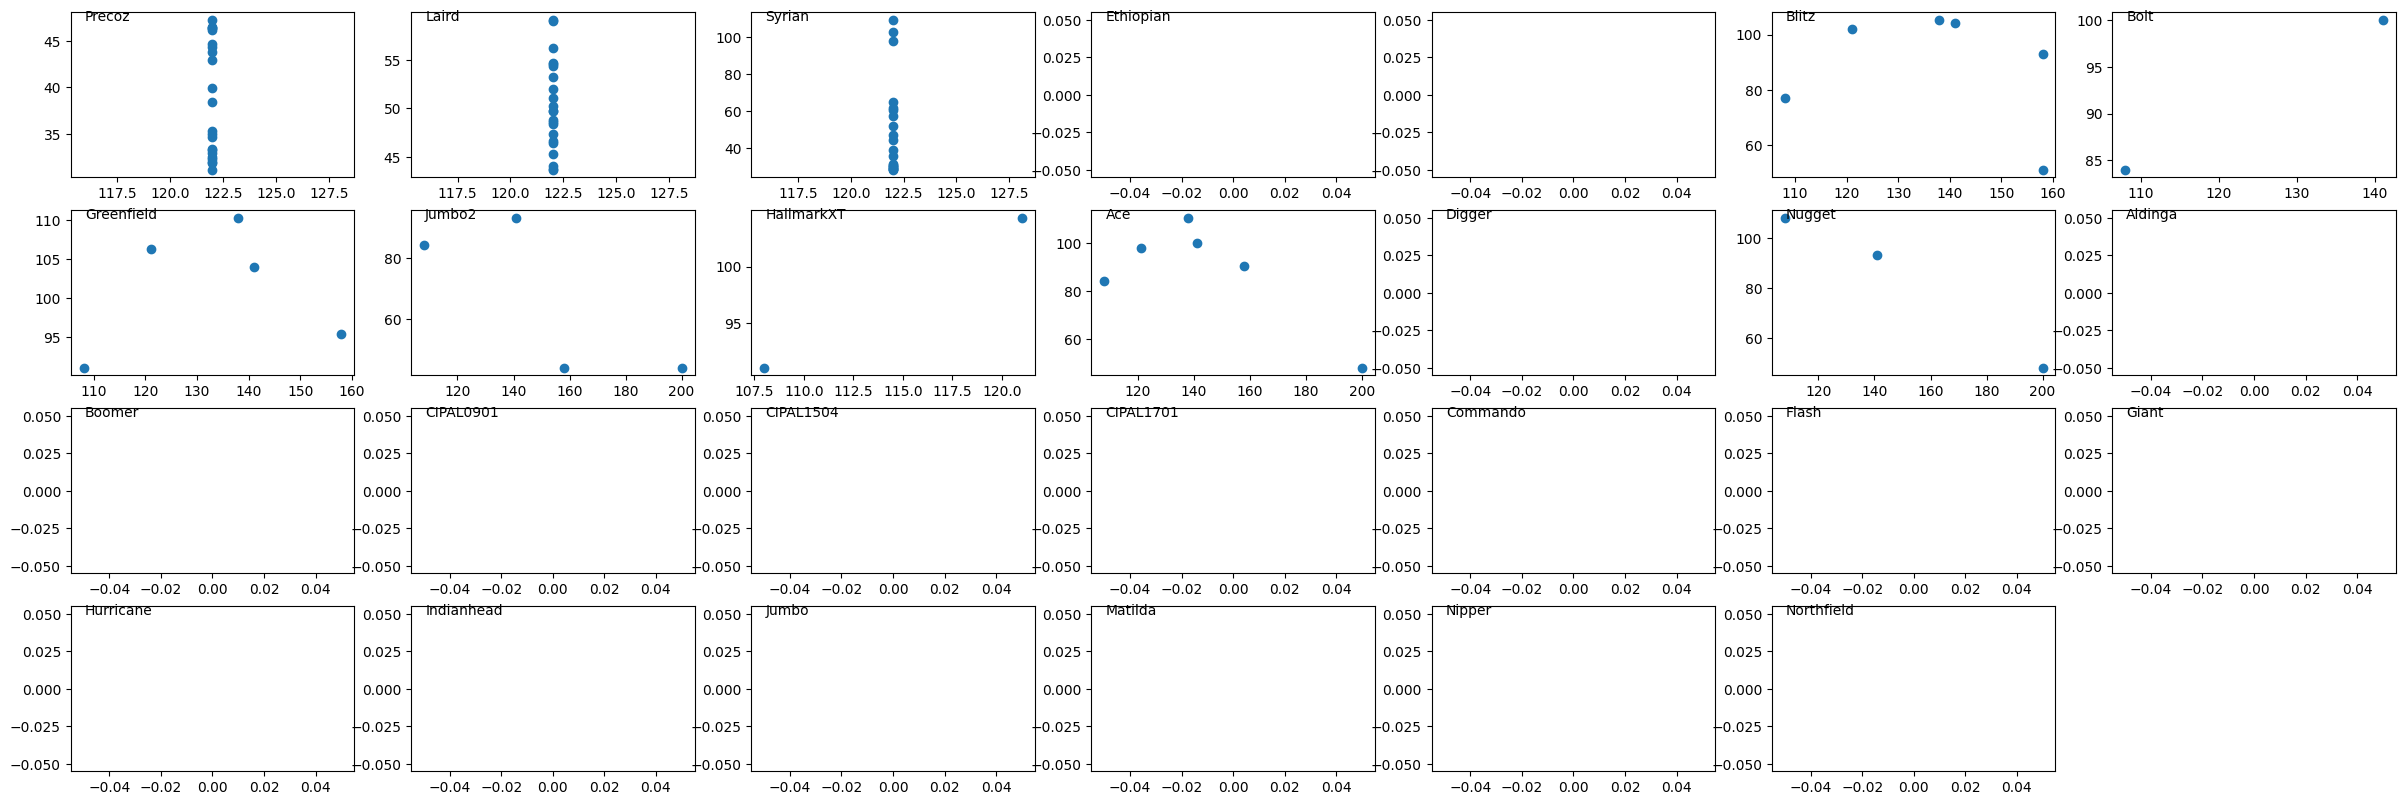

In [200]:
graph = plt.figure(figsize=(30,15))
pos=1
for c in Cultivars:
    ax = graph.add_subplot(6,7,pos)
    cultFilt = ObsPhen.loc[:,'Lentil.SowingData.Cultivar'] == c
    plt.plot(ObsPhen.loc[cultFilt,'SowDOY'],ObsPhen.loc[cultFilt,'StartBuddingDAS'],'o')
    plt.text(0.05,0.95,c,transform = ax.transAxes)
    pos +=1


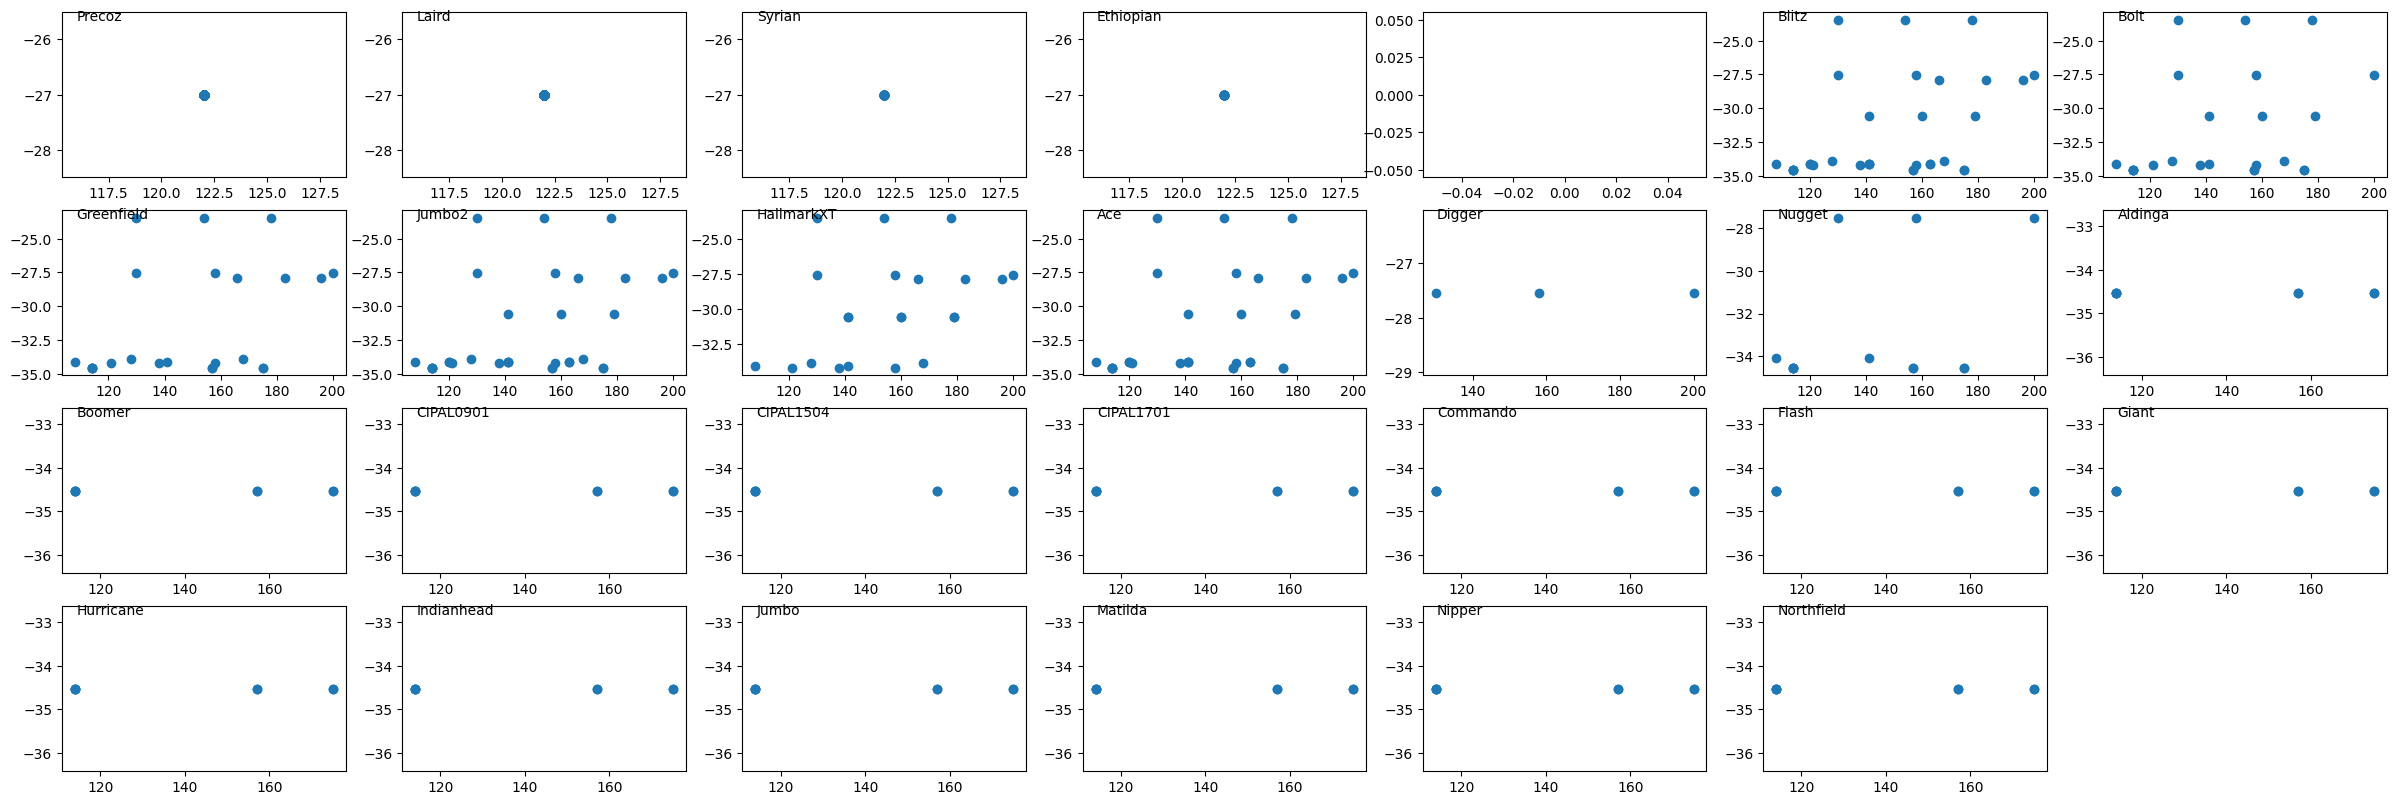

In [201]:
graph = plt.figure(figsize=(30,15))
pos=1
for c in Cultivars:
    ax = graph.add_subplot(6,7,pos)
    cultFilt = SowReport.Cv == c
    plt.plot(SowReport.loc[cultFilt,'SowDOY'],SowReport.loc[cultFilt,'IWeather.Latitude'],'o')
    plt.text(0.05,0.95,c,transform = ax.transAxes)
    pos +=1


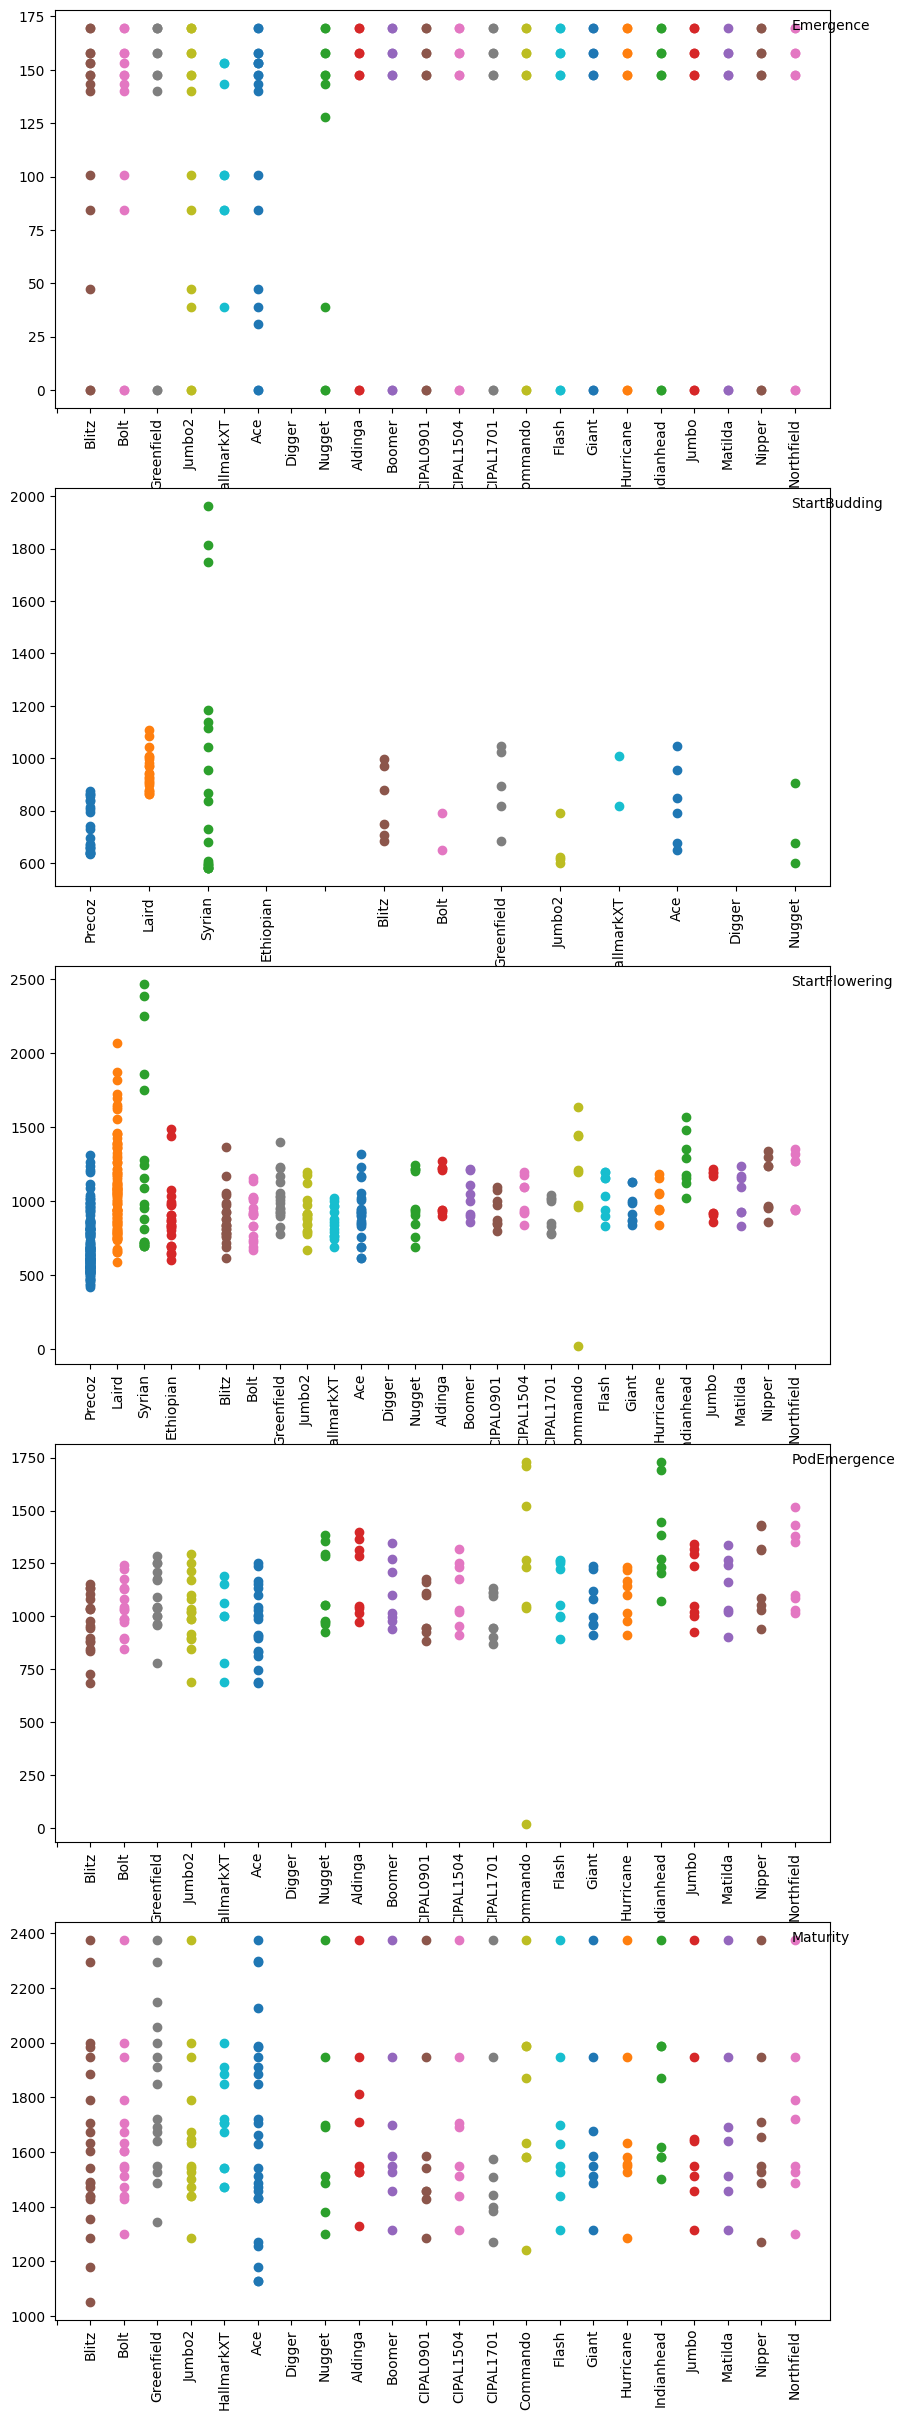

In [202]:
graph = plt.figure(figsize = (10,30))
pos = 1
for s in Stage.index:
    ax = graph.add_subplot(5,1,pos)
    plt.text(0.95,0.95,s,transform = ax.transAxes)
    ax.set_xticks(list(range(len(Cultivars))))
    ax.set_xticklabels(Cultivars)
    plt.xticks(rotation=90)
    pos +=1
    ind = 0
    for c in Cultivars:
        cultFilt = ObsPhen.loc[:,'Lentil.SowingData.Cultivar'] == c
        data = ObsPhen.loc[cultFilt, Stage.loc[s,'Tt']]
        x = [ind] * len(data)
        plt.plot(x,data,'o')
        
        ind += 1

In [203]:
Stage

,DAS,Date,Tt,VarName
Emergence,EmergenceDAS,EmergenceDate,EmergenceTt,Observed.Lentil.Phenology.EmergenceDAS
StartBudding,StartBuddingDAS,StartBuddingDate,StartBuddingTt,Observed.Lentil.Phenology.StartBuddingDAS
StartFlowering,StartFloweringDAS,StartFloweringDate,StartFloweringTt,Observed.Lentil.Phenology.StartFloweringDAS
PodEmergence,PodEmergenceDAS,PodEmergenceDate,PodEmergenceTt,Observed.Lentil.Phenology.PodEmergenceDAS
Maturity,MaturityDAS,MaturityDate,MaturityTt,Observed.Lentil.Phenology.MaturityDAS


In [204]:
ParameterValues

Tt,EmergenceTt,StartBuddingTt,StartFloweringTt,PodEmergenceTt,MaturityTt
Precoz,160,588,138.7557,97,492
Laird,160,588,198.599946,97,492
Syrian,160,588,112.587712,97,492
Ethiopian,160,588,103,97,492
None,160,588,103,97,492
Blitz,157.380448,587.602539,72.032416,116.069578,506.171755
Greenfield,160.148716,580.385748,184.307784,114.950097,674.401912
Bolt,157.492432,560.551873,88.318861,108.791683,562.905718
HallmarkXT,109.164417,655.498858,50.004715,101.582487,845.132126
Jumbo2,152.11609,555.176298,93.764163,102.543583,515.813939


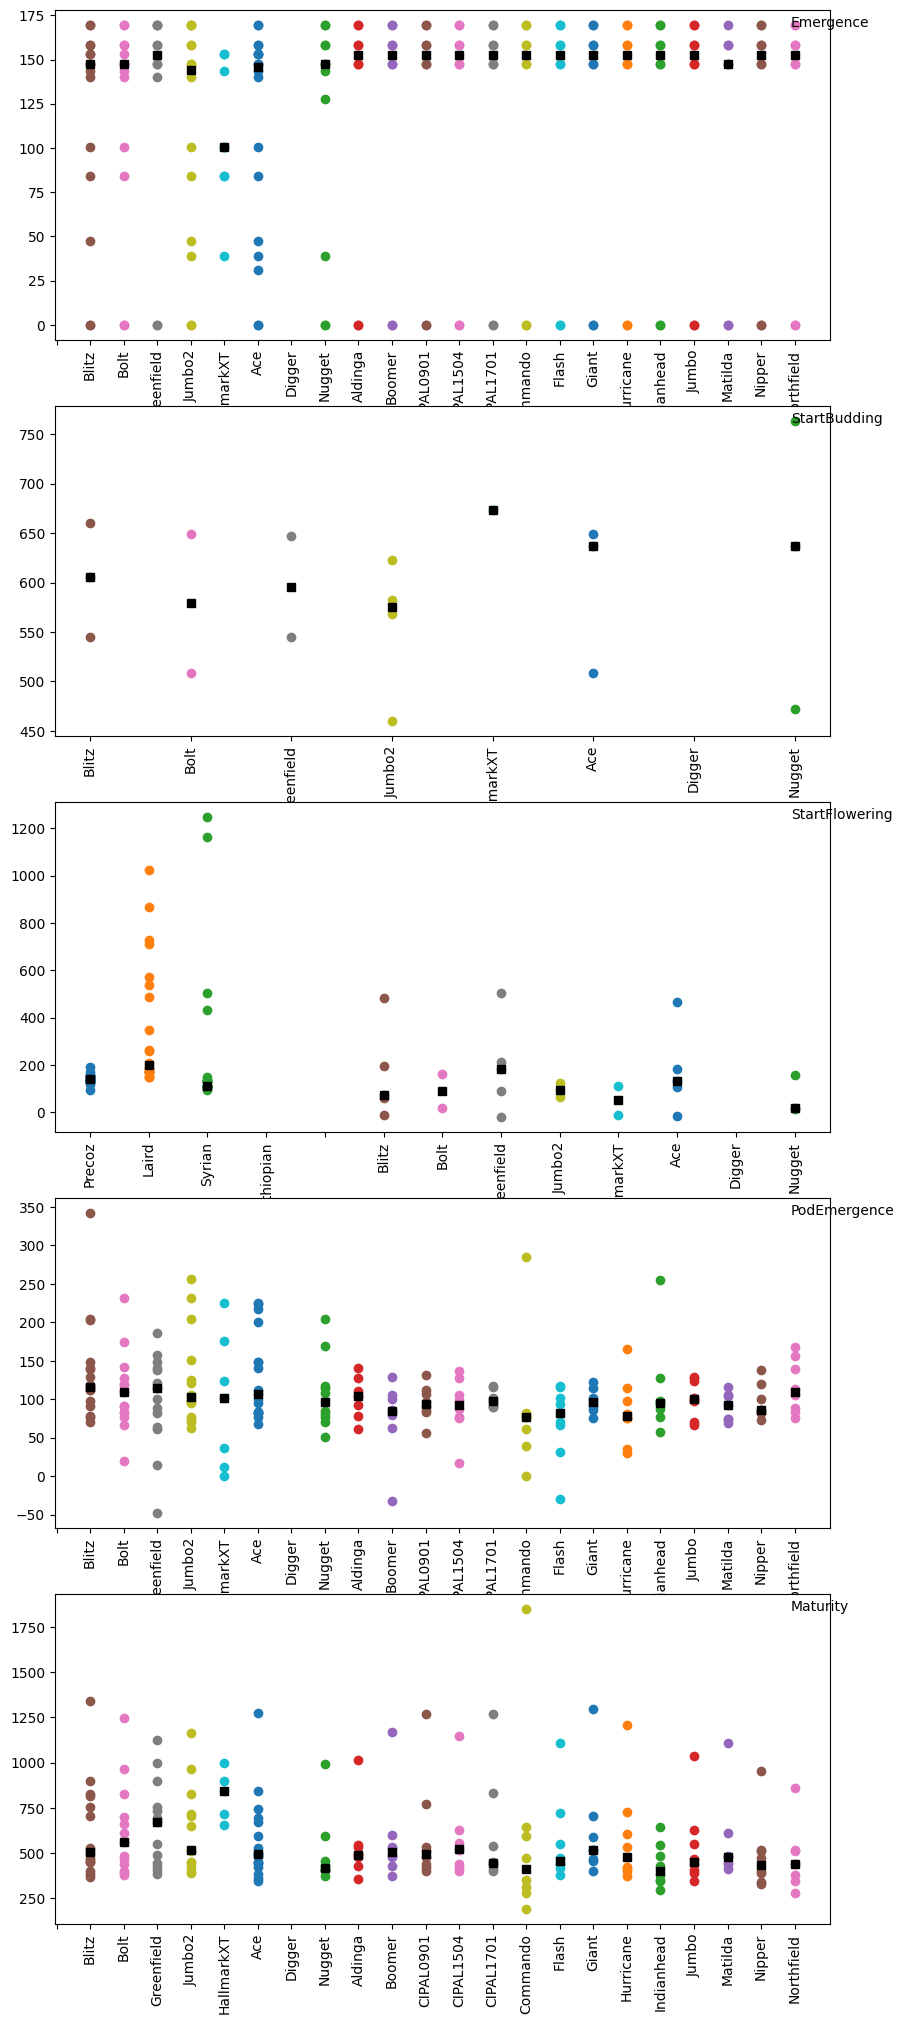

In [205]:
ParameterValues = pd.DataFrame(index = Cultivars, columns = Stage.Tt)
graph = plt.figure(figsize = (10,30))
pos = 1
for s in Stage.index:
    ax = graph.add_subplot(6,1,pos)
    plt.text(0.95,0.95,s,transform = ax.transAxes)
    ax.set_xticks(list(range(len(Cultivars))))
    ax.set_xticklabels(Cultivars)
    plt.xticks(rotation=90)
    
    ind = 0
    for c in Cultivars:
        cultFilt = ObsPhen.loc[:,'Lentil.SowingData.Cultivar'] == c
        if pos>1:
            data = ObsPhen.loc[cultFilt, Stage.loc[s,'Tt']] - ObsPhen.loc[cultFilt, Stage.iloc[pos-2,:]['Tt']]
        else:
            data = ObsPhen.loc[cultFilt, Stage.loc[s,'Tt']]
        x = [ind] * len(data)
        plt.plot(x,data,'o')
        plt.plot(ind,data.median(),'s',color='k')
        ParameterValues.loc[c,s+'Tt'] = data.median()
        ind += 1
    pos +=1

In [206]:
for col in ParameterValues.columns:
    ParameterValues.loc[:,col] = ParameterValues.loc[:,col].where([~np.isnan(x) for x in ParameterValues.loc[:,col]],
                                       other=round(ParameterValues.loc[:,col] .median()))
ParameterValues

Tt,EmergenceTt,StartBuddingTt,StartFloweringTt,PodEmergenceTt,MaturityTt
Precoz,153,605,138.7557,97,492
Laird,153,605,198.599946,97,492
Syrian,153,605,112.587712,97,492
Ethiopian,153,605,103,97,492
None,153,605,103,97,492
Blitz,147.650001,605.102539,72.032416,116.069578,506.171755
Bolt,147.650001,578.949003,88.318861,108.791683,562.905718
Greenfield,152.825001,595.908387,184.307784,114.950097,674.401912
Jumbo2,143.900001,575.462596,93.764163,102.543583,515.813939
HallmarkXT,100.5,672.998858,50.004715,101.582487,845.132126
